# Project: Investigating the IMDB Movie Dataset
#### *"What it takes to make a great movie"*
#### Analysis by Patrick Flynn

## Table of Contents
<ul>
<li><a href="#intro">Introduction</a></li>
<li><a href="#wrangling">Data Wrangling</a></li>
<li><a href="#eda">Exploratory Data Analysis</a></li>
<li><a href="#conclusions">Conclusions</a></li>
<li><a href="#references">References</a></li>
</ul>

<a id='intro'></a>
## Introduction

For this analysis, we will assume we are a screenwriter looking to make the next big blockbuster film! We are armed with an IMDB data set and our goal is to determine what genre(s) of movie we should write and what features will best determine if our movie will be profitable.

> **Data Source**: [IMDB Dataset](https://www.google.com/url?q=https://d17h27t6h515a5.cloudfront.net/topher/2017/October/59dd1c4c_tmdb-movies/tmdb-movies.csv&sa=D&ust=1532469042115000)


### Libraries/Packages Utilized

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MultiLabelBinarizer

<a id='wrangling'></a>
# Data Wrangling

### Data Acquisition

Read in data from CSV and preview first 5 records

In [2]:
df = pd.read_csv(r'S:\Code\School\WGU_DataAnalyst_NanoDegree\01 - Introduction to Data Science\tmdb-movies.csv')
df.head()

id    imdb_id  popularity     budget     revenue  \
0  135397  tt0369610   32.985763  150000000  1513528810   
1   76341  tt1392190   28.419936  150000000   378436354   
2  262500  tt2908446   13.112507  110000000   295238201   
3  140607  tt2488496   11.173104  200000000  2068178225   
4  168259  tt2820852    9.335014  190000000  1506249360   

                 original_title  \
0                Jurassic World   
1            Mad Max: Fury Road   
2                     Insurgent   
3  Star Wars: The Force Awakens   
4                     Furious 7   

                                                cast  \
0  Chris Pratt|Bryce Dallas Howard|Irrfan Khan|Vi...   
1  Tom Hardy|Charlize Theron|Hugh Keays-Byrne|Nic...   
2  Shailene Woodley|Theo James|Kate Winslet|Ansel...   
3  Harrison Ford|Mark Hamill|Carrie Fisher|Adam D...   
4  Vin Diesel|Paul Walker|Jason Statham|Michelle ...   

                                            homepage          director  \
0                      http://www.jurassicworld.com/   Colin Trevorrow   
1                        http://www.madmaxmovie.com/     George Miller   
2     http://www.thedivergentseries.movie/#insurgent  Robert Schwentke   
3  http://www.starwars.com/films/star-wars-episod...       J.J. Abrams   
4                           http://www.furious7.com/         James Wan   

                         tagline  ...  \
0              The park is open.  ...   
1             What a Lovely Day.  ...   
2     One Choice Can Destroy You  ...   
3  Every generation has a story.  ...   
4            Vengeance Hits Home  ...   

                                            overview runtime  \
0  Twenty-two years after the events of Jurassic ...     124   
1  An apocalyptic story set in the furthest reach...     120   
2  Beatrice Prior must confront her inner demons ...     119   
3  Thirty years after defeating the Galactic Empi...     136   
4  Deckard Shaw seeks revenge against Dominic Tor...     137   

                                      genres  \
0  Action|Adventure|Science Fiction|Thriller   
1  Action|Adventure|Science Fiction|Thriller   
2         Adventure|Science Fiction|Thriller   
3   Action|Adventure|Science Fiction|Fantasy   
4                      Action|Crime|Thriller   

                                production_companies release_date vote_count  \
0  Universal Studios|Amblin Entertainment|Legenda...       6/9/15       5562   
1  Village Roadshow Pictures|Kennedy Miller Produ...      5/13/15       6185   
2  Summit Entertainment|Mandeville Films|Red Wago...      3/18/15       2480   
3          Lucasfilm|Truenorth Productions|Bad Robot     12/15/15       5292   
4  Universal Pictures|Original Film|Media Rights ...       4/1/15       2947   

   vote_average  release_year    budget_adj   revenue_adj  
0           6.5          2015  1.379999e+08  1.392446e+09  
1           7.1          2015  1.379999e+08  3.481613e+08  
2           6.3          2015  1.012000e+08  2.716190e+08  
3           7.5          2015  1.839999e+08  1.902723e+09  
4           7.3          2015  1.747999e+08  1.385749e+09  

[5 rows x 21 columns]

Inspect object types/missing data

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10866 entries, 0 to 10865
Data columns (total 21 columns):
id                      10866 non-null int64
imdb_id                 10856 non-null object
popularity              10866 non-null float64
budget                  10866 non-null int64
revenue                 10866 non-null int64
original_title          10866 non-null object
cast                    10790 non-null object
homepage                2936 non-null object
director                10822 non-null object
tagline                 8042 non-null object
keywords                9373 non-null object
overview                10862 non-null object
runtime                 10866 non-null int64
genres                  10843 non-null object
production_companies    9836 non-null object
release_date            10866 non-null object
vote_count              10866 non-null int64
vote_average            10866 non-null float64
release_year            10866 non-null int64
budget_adj              1

> **Analysis Note**: Several columns are not relavant to the analysis and need to be removed. In addition, there are some important fields (IMDB_ID, Genres) that are missing records and will be removed from the dataset. These values cannot be imputed.

## Data Cleaning (Replace this with more specific notes!)

Rows are dropped from Genres/IMDB_ID that are null. Columns are dropped that are not relavant to analysis (see analyst note)

In [4]:
df.dropna(subset=['genres', 'imdb_id'], inplace=True)
df.drop(axis=1, columns=['homepage', 'tagline', 
                         'keywords', 'production_companies',
                        'cast', 'director', 'overview'], inplace=True)

> **Analysis Note**: The fields that are dropped could be of great importance for a future project utilizing natural language processing. However that is beyond the scope of this assignment.


#### Create function to turn lists nested in genres column to new columns for each genre

In [5]:
def transform_lists_to_columns(dataframe, column):
    mlb = MultiLabelBinarizer()
    dataframe[column] = dataframe[column].str.split('|')
    dataframe.apply(lambda x: tuple(x[column]), axis=1)
    dataframe = dataframe.join(pd.DataFrame(mlb.fit_transform(dataframe[column]), 
                                            columns=mlb.classes_, 
                                            index=dataframe.index))
    dataframe.drop(axis=1, columns=[column], inplace=True)
    return dataframe

> **Analysis Note**: This function will take the "genres" column and create a new column for each value discovered in the column. This will make analysis of individual genres FAR easier. Because this is the primary question involved in our research (to discover what genre to write), this function is incredibly important.

#### Run function on column and view subset

In [6]:
df = transform_lists_to_columns(df, 'genres')
genre_cols = list(df.columns[-20:])
df.loc[:, genre_cols].head()

Action  Adventure  Animation  Comedy  Crime  Documentary  Drama  Family  \
0       1          1          0       0      0            0      0       0   
1       1          1          0       0      0            0      0       0   
2       0          1          0       0      0            0      0       0   
3       1          1          0       0      0            0      0       0   
4       1          0          0       0      1            0      0       0   

   Fantasy  Foreign  History  Horror  Music  Mystery  Romance  \
0        0        0        0       0      0        0        0   
1        0        0        0       0      0        0        0   
2        0        0        0       0      0        0        0   
3        1        0        0       0      0        0        0   
4        0        0        0       0      0        0        0   

   Science Fiction  TV Movie  Thriller  War  Western  
0                1         0         1    0        0  
1                1         0         1    0        0  
2                1         0         1    0        0  
3                1         0         0    0        0  
4                0         0         1    0        0

The for each genre, a column inidicating a true(1) or false(0) exists for each movie.

#### Feature Engineering
Create a "profit" variable that will determine if money was made (i.e. did the movie make more than it cost?)

In [7]:
df['profit'] = df.revenue_adj - df.budget_adj

Convert release date to datetime and ensure all columns are of proper data type and all data is present

In [8]:
#Convert release date to proper DateTime Object
df['release_date'] = pd.to_datetime(df['release_date'])

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10835 entries, 0 to 10865
Data columns (total 34 columns):
id                 10835 non-null int64
imdb_id            10835 non-null object
popularity         10835 non-null float64
budget             10835 non-null int64
revenue            10835 non-null int64
original_title     10835 non-null object
runtime            10835 non-null int64
release_date       10835 non-null datetime64[ns]
vote_count         10835 non-null int64
vote_average       10835 non-null float64
release_year       10835 non-null int64
budget_adj         10835 non-null float64
revenue_adj        10835 non-null float64
Action             10835 non-null int32
Adventure          10835 non-null int32
Animation          10835 non-null int32
Comedy             10835 non-null int32
Crime              10835 non-null int32
Documentary        10835 non-null int32
Drama              10835 non-null int32
Family             10835 non-null int32
Fantasy            10835 non-nul

> **Analysis Note**: All fields now have the same amount of records and there are no nulls. In our cleaning, we only removed approximately 30 records and all fields are the proper data type.

<a id='eda'></a>
## Exploratory Data Analysis

### Research Question 1: What Genre of Movie Gets Produced the Most?

Create sub-dataframe that will hold only columns of genres occuring since 1996

In [10]:
vis_data = df.groupby('release_year').sum()[genre_cols]
vis_data = vis_data.loc[vis_data.index > 1995, :]

Create heatmap based on visualization dataframe created above:

[Text(201.5,0.5,'Year'), Text(0.5,111.453,'Genre')]

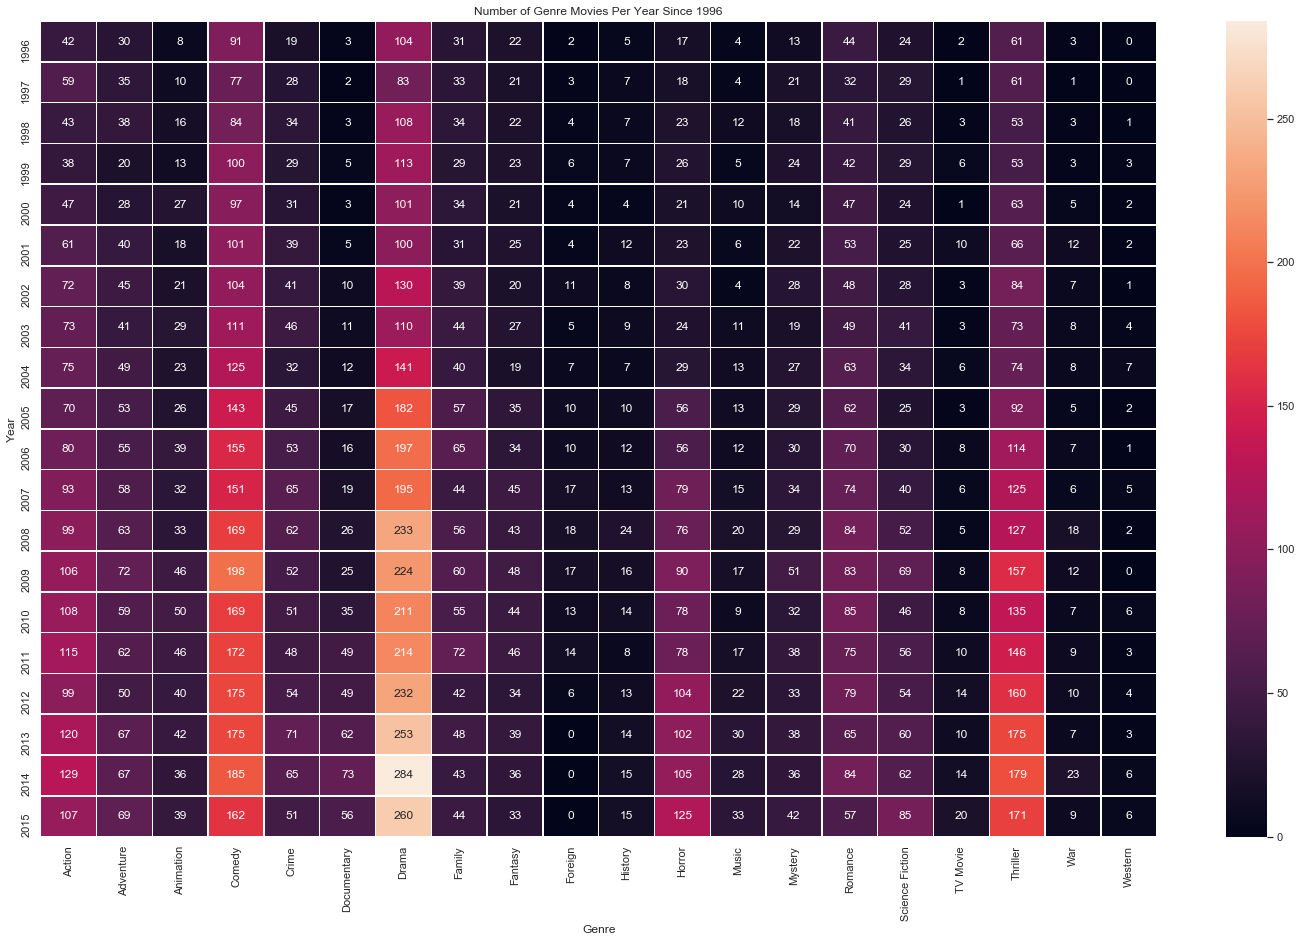

In [11]:
sns.set()

# Draw a heatmap with the numeric values in each cell
f, ax = plt.subplots(figsize=(25, 15))
g = sns.heatmap(vis_data, annot=True, fmt="d", linewidths=.5, ax=ax)
g.set(title = 'Number of Genre Movies Per Year Since 1996')
g.set(xlabel='Genre', ylabel='Year')

The above visualization shows three very clear genres that rise against others: Comedy, Drama, Thriller. Movies to stay away from are Foreign/History/War.

### Create Regression/Line Plots
Function to create regression/line subplots and label axis based on column from DF sent to function

In [12]:
def create_genre_plots(col, adjusted_y='Billions of Dollars'):
    query_string = col + ' == 1'
    movie_data = df.query(query_string)[['release_year','revenue_adj']].groupby('release_year').sum()
    movie_data = movie_data.reset_index()
    fig, axs = plt.subplots(ncols=2, figsize=(15, 5))
    g = sns.regplot(x="release_year", y="revenue_adj",  data=movie_data, ax=axs[0])
    g.set(xlabel='Year', ylabel=adjusted_y)
    g.set(title = col + ' - Regression Scatter Plot')
    gt = sns.lineplot(x="release_year", y="revenue_adj",  data=movie_data, ax=axs[1])
    gt.set(xlabel='Year', ylabel=adjusted_y)
    gt.set(title = col + ' - Line Plot')
    plt.suptitle(col + ' Visualization Data')

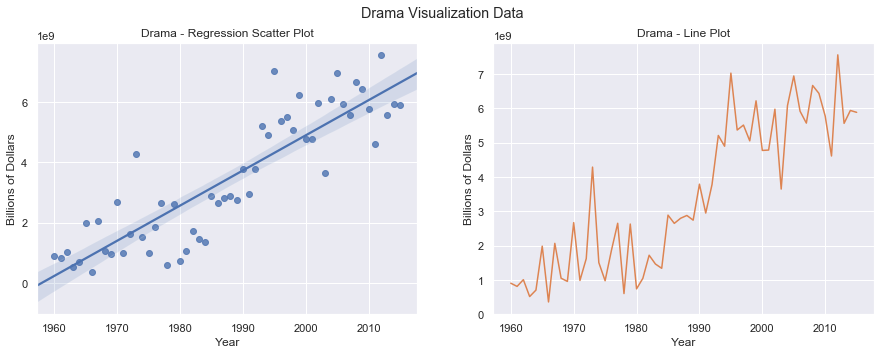

In [13]:
create_genre_plots('Drama')

The Drama genre is one of the highest performing genres. While there are a few years in the 2000's that dipped lower than other years, the genre still performs very well and the Regression plot shows an upwards trend.

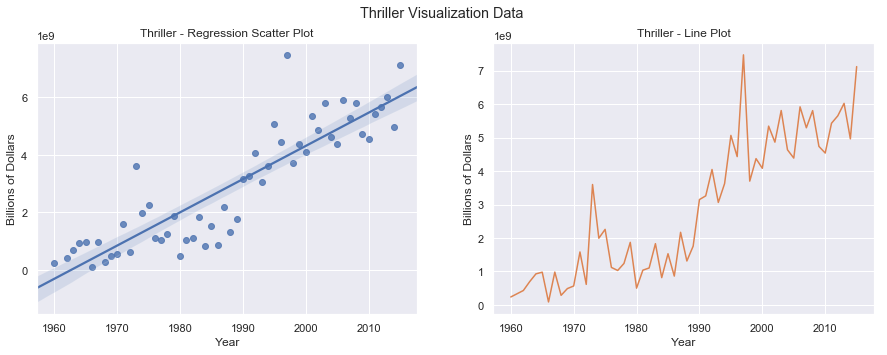

In [14]:
create_genre_plots('Thriller')

The thriller genre is also a high performing genre, however, since the 2000's the genre doesn't seem "AS" stable as the Drama genre.

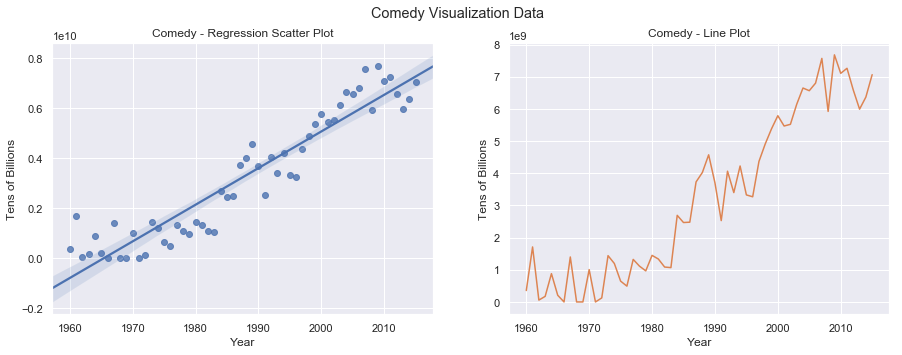

In [15]:
create_genre_plots('Comedy', adjusted_y='Tens of Billions')

The comedy genre appears to be the best suited for future growth and has had some of the highest performing years compared to other genres. The mid 90's appear to be a huge boom in comedy.

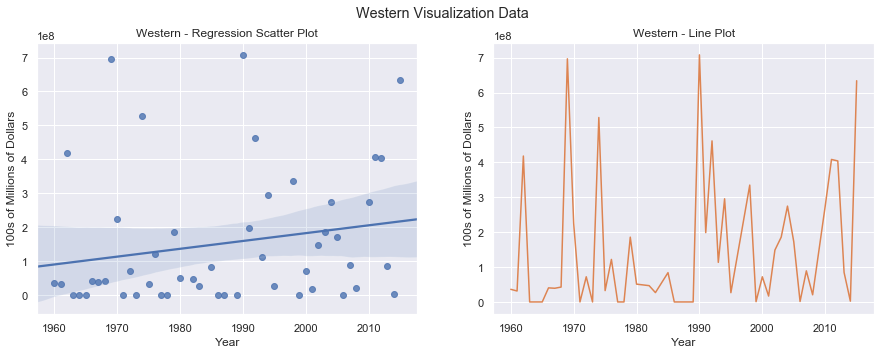

In [16]:
create_genre_plots('Western', adjusted_y='100s of Millions of Dollars')

This visualization included to shown a potential genre to stay away from. Western films have their periodic blockbusters, but overwhelmingly they do not do well in the box office.

### Research Question 2: What, If Any, Features Impact the Revenue a Movie Will Make?

There are no **STRONG** relationships between any of the genres and revenue (revenue_adj). Based on the below correlation matrix, it would appear that a good indicator factor that influences revenue is the budget. As the budget increases, so too does the revenue. The popularity of the movie and the number of votes for the movie also strongly influences the revenue of the movie. This makes sense from a practical standpoint, after all, the more popular a movie is the more people that will see it (earning the film more revenue) 

In [17]:
df.corr()

id  popularity    budget   revenue   runtime  \
id               1.000000   -0.012986 -0.140604 -0.098664 -0.085653   
popularity      -0.012986    1.000000  0.545205  0.663244  0.138337   
budget          -0.140604    0.545205  1.000000  0.734797  0.190960   
revenue         -0.098664    0.663244  0.734797  1.000000  0.162720   
runtime         -0.085653    0.138337  0.190960  0.162720  1.000000   
vote_count      -0.034709    0.800779  0.632544  0.791105  0.163153   
vote_average    -0.061468    0.211060  0.082210  0.173758  0.159131   
release_year     0.511222    0.090458  0.116616  0.057491 -0.117246   
budget_adj      -0.188361    0.513239  0.968944  0.706311  0.220855   
revenue_adj     -0.138027    0.608931  0.622336  0.919082  0.175587   
Action          -0.076193    0.148205  0.224928  0.149368  0.048667   
Adventure       -0.073087    0.200794  0.293414  0.247990  0.051270   
Animation        0.006790    0.053847  0.072517  0.079536 -0.284309   
Comedy          -0.098170   -0.040330 -0.032392 -0.015040 -0.127281   
Crime           -0.074423    0.036646  0.036716  0.007748  0.057376   
Documentary      0.148038   -0.104440 -0.102120 -0.072552  0.004590   
Drama           -0.044426   -0.049640 -0.079447 -0.080826  0.235682   
Family          -0.059625    0.049707  0.100729  0.099447 -0.143662   
Fantasy         -0.063512    0.105240  0.176954  0.146804 -0.012750   
Foreign         -0.047649   -0.060556 -0.056750 -0.043577  0.021537   
History         -0.025694   -0.012796  0.022634 -0.012066  0.194217   
Horror           0.044792   -0.076861 -0.115071 -0.083240 -0.104410   
Music            0.023911   -0.031456 -0.033233 -0.019049  0.017905   
Mystery         -0.031197    0.011992  0.013335  0.000680  0.034248   
Romance         -0.072956   -0.024095 -0.029904 -0.015699  0.065536   
Science Fiction -0.021903    0.127193  0.120116  0.092752 -0.028530   
TV Movie         0.070625   -0.047096 -0.058220 -0.042386 -0.040741   
Thriller        -0.024304    0.056708  0.049802  0.009188  0.020963   
War             -0.019881    0.012759  0.032154  0.010464  0.130213   
Western         -0.030643   -0.007099  0.017306 -0.012068  0.061313   
profit          -0.107826    0.562728  0.453391  0.868064  0.142307   

                 vote_count  vote_average  release_year  budget_adj  \
id                -0.034709     -0.061468      0.511222   -0.188361   
popularity         0.800779      0.211060      0.090458    0.513239   
budget             0.632544      0.082210      0.116616    0.968944   
revenue            0.791105      0.173758      0.057491    0.706311   
runtime            0.163153      0.159131     -0.117246    0.220855   
vote_count         1.000000      0.255265      0.108466    0.586865   
vote_average       0.255265      1.000000     -0.120723    0.094355   
release_year       0.108466     -0.120723      1.000000    0.017367   
budget_adj         0.586865      0.094355      0.017367    1.000000   
revenue_adj        0.707839      0.194373     -0.065971    0.646446   
Action             0.161743     -0.106951     -0.052472    0.238341   
Adventure          0.203301     -0.014475     -0.059661    0.304411   
Animation          0.039036      0.120565      0.054679    0.059302   
Comedy            -0.052815     -0.053459     -0.028383   -0.035827   
Crime              0.039832      0.061131     -0.053401    0.043360   
Documentary       -0.071149      0.224410      0.122373   -0.110886   
Drama             -0.054300      0.181798     -0.026274   -0.070570   
Family             0.033886      0.008981     -0.015076    0.097376   
Fantasy            0.107426     -0.036688     -0.024633    0.176235   
Foreign           -0.046422      0.001183      0.000933   -0.058902   
History           -0.010580      0.083540     -0.053051    0.046516   
Horror            -0.071665     -0.287162     -0.006311   -0.120838   
Music             -0.031996      0.106231     -0.017528   -0.026351   
Mystery            0.009390     -0.007999     

### Research Question 3: Is One Genre More Profitable or Risky Than Another?

Two dataframes are created that contain movies that have lost more than 0 dollars (losses DF) and movies that have profitted more than 1,000,000 dollars. It is important to look at both losses and profits, especially if one of our target genres has far more losses or profits versus the other genres.

In [18]:
profits = df[df.index > 1995].query("profit >= 1000000")[genre_cols]
losses = df[df.index > 1995].query("profit < 0")[genre_cols]
profits = pd.DataFrame(profits.sum()).reset_index().rename(columns={'index':'genre', 0:'Num_Movies'})
losses = pd.DataFrame(losses.sum()).reset_index().rename(columns={'index':'genre', 0:'Num_Movies'})

> **Analysis Note:** Each dataframe is created, aggregated by genre, and given new column names

#### Visualization to Compare Profits/Losses

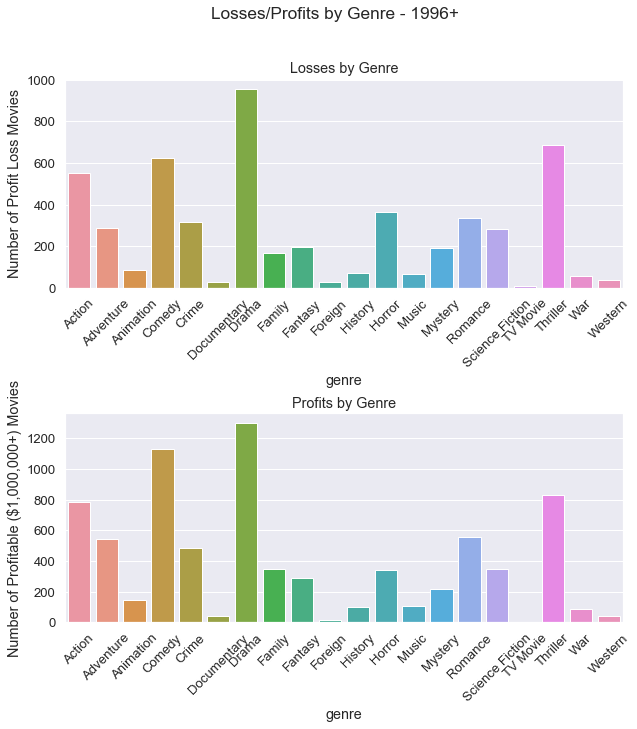

In [19]:
#Ensure font size is viewable
sns.set(font_scale = 1.2)
#Create two rows of one column each
fig, axs = plt.subplots(nrows=2, figsize=(10, 10))

#Losses graph
g = sns.barplot(x='genre', y='Num_Movies', data=losses, ax=axs[0])
g.set(ylabel='Number of Profit Loss Movies')
g.set(title = 'Losses by Genre')

#profits graph
gr = sns.barplot(x='genre', y='Num_Movies', data=profits, ax=axs[1])
gr.set(ylabel='Number of Profitable ($1,000,000+) Movies')
gr.set(title = 'Profits by Genre')

#Tilt axis ticks for each figure
for ax in fig.axes:
    plt.sca(ax)
    plt.xticks(rotation=45)
plt.suptitle('Losses/Profits by Genre - 1996+')
#Add space between two plots
plt.subplots_adjust(hspace = 0.6)

It can be seen that large profits and losses tend to occur in the same categories (Comedy, Drama, and Thriller). These also are the same genres of movies that have the highest amount of movies made. It is likely that people like these movie genres the most and because of this, these genres are written the most. This data indicates that a comedy movie still has better profitability than dramas/thrillers.

<a id='conclusions'></a>
## Conclusions

Based on the analysis above, one winner emerges from the highest performing/earning genres: Comedy. The comedy genre has seen a steady increase since the mid 1980s. While the genre is clearly a popular one and one of the highest revenue earning, more important is making a movie that is popular and has a high budget as these features are often correlated with higher revenue.

While the Comedy genre looks promising, the main takeaway from this analysis is that while Comedies/Dramas/Thrillers are the most produced movies; they are also the movies with the largest losses. Having a marketing/PR team would prove to be almost as important as choosing the right genre!

##### Future Analysis:
- Do certain words in the title impact the profits/revenue of a movie?
- Do certain production studios have consistently higher revenues/losses? (i.e. should a screenwriter seek to work for these?)
- Do blended genres (i.e. Romantic Comedies) have higher revenues than just solo genres?

<a id='references'></a>
## References

[Proper Utilization of Multilabel Binarizer](https://chrisalbon.com/machine_learning/preprocessing_structured_data/one-hot_encode_features_with_multiple_labels/)

[Pandas API](https://pandas.pydata.org/pandas-docs/stable/reference/index.html)

[Seaborn Visualization API](https://seaborn.pydata.org/api.html)